In [1]:
import os ; os.environ['OMP_NUM_THREADS'] = os.environ.get('OMP_NUM_THREADS', '1')
print('Parrallel:', int(os.environ.get('OMP_NUM_THREADS')) > 1)

Parrallel: False


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import frank
frank.enable_logging()

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset

In [3]:
%matplotlib inline
%matplotlib notebook

In [4]:
plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'axes.linewidth': 1.25})
plt.rcParams.update({'axes.labelpad': 5})

plt.rcParams.update({'xtick.major.size': 7.5})
plt.rcParams.update({'xtick.minor.size': 4.0})
plt.rcParams.update({'ytick.major.size': 7.5})
plt.rcParams.update({'ytick.minor.size': 4.0})

plt.rcParams.update({'xtick.major.width': 1.5})
plt.rcParams.update({'ytick.major.width': 1.5})
plt.rcParams.update({'xtick.minor.width': 1.0})
plt.rcParams.update({'ytick.minor.width': 1.0})

plt.rcParams.update({'xtick.major.pad': 5})
plt.rcParams.update({'ytick.major.pad': 5})

plt.rcParams.update({'xtick.top': True})
plt.rcParams.update({'ytick.right': True})
plt.rcParams.update({'xtick.labeltop': False})
plt.rcParams.update({'ytick.labelright': False})

plt.rcParams.update({'xtick.direction': "in"})
plt.rcParams.update({'ytick.direction': "in"})

In [5]:
def load_uv_table(uvtable,restable,geom):
    """
    Load the u,v points, visibilities, weights, and residuals from uvtables.
    Parameters:
     filename:  uvtable (from extract_uvtable)
     residuals: residual uvtable (from frank)
     geom:      geometry object (fits in /statwt/fits.ipynb)
    Returns: up, vp, visp, visp_res, w
    """
    
    u, v, vis, w = frank.io.load_uvtable(uvtable)
    
    up, vp, visp = geom.apply_correction(u, v, vis)
    
    vis_res      = frank.io.load_uvtable(restable)[2]
    
    visp_res     = geom.apply_correction(u, v, vis_res)[2]

    return up, vp, visp, visp_res, w

In [6]:
def plot_paper(
        data,filename = '../nostatwt/band7/CI_Tau_B7_frank_visibilities_bestfit.dat',PSsub=0.,
        ylim=[-10,25],ylim_res=[-7.5,7.5],ylim_axin=[5e-1,1e3],xlim=[-0.15936235803021218, 3.65936235803021218],
        titlename='ALMA Band 7',figname='./band7_visfit.pdf',axin_position=[0.9,0.9,0.1,0.1],
        labelpad_vis=4.,labelpad_res=14.,
    ):
    
    #unpack data:
    up, vp, visp, visp_res, w = data
    qp                        = np.hypot(up,vp)
    
    #init figure:
    fig, axs = plt.subplots(2,1,figsize=(10,4.5),sharex=True,gridspec_kw={'height_ratios':[1,0.25]})

    axin = inset_axes(
        axs[0], 
        width  = 2.85,
        height = 1.75,
        loc    = 'upper right',
        bbox_to_anchor=axin_position, 
        bbox_transform=axs[0].figure.transFigure,
        borderpad = 0.5,
    )   

    axin.set_ylim(ylim_axin[0],ylim_axin[1])

    #plot data
    binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp*1e3, w, 1e4)
    axs[0].errorbar(binned_vis.uv/1e6, binned_vis.V.real,         binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.', capsize=2.5, capthick=0.5, alpha=0.5, zorder=-1)

    axin.errorbar(  binned_vis.uv/1e6, np.abs(binned_vis.V.real), binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.', capsize=2.5, capthick=0.5, alpha=0.5, zorder=-1)

    binned_res = frank.utilities.UVDataBinner(np.hypot(up,vp), visp_res*1e3, w, 1e4)
    axs[1].errorbar(binned_res.uv/1e6, binned_res.V.real,         binned_res.error.real, ls='none', lw=0.5, c='gray', marker='.', capsize=2.5, capthick=0.5, alpha=0.5, zorder=-1)

    binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp*1e3, w, 1e5)
    axs[0].errorbar(binned_vis.uv/1e6, binned_vis.V.real,         binned_vis.error.real, ls='none', lw=0.5, c='k',    marker='.', capsize=2.5, capthick=0.5, ms=7.5, zorder=10)

    axin.errorbar(  binned_vis.uv/1e6, np.abs(binned_vis.V.real), binned_vis.error.real, ls='none', lw=0.5, c='k',    marker='.', capsize=2.5, capthick=0.5, ms=7.5, zorder=10)

    binned_res = frank.utilities.UVDataBinner(np.hypot(up,vp), visp_res*1e3, w, 1e5)
    axs[1].errorbar(binned_res.uv/1e6, binned_res.V.real,         binned_res.error.real, ls='none', lw=0.5, c='k',    marker='.', capsize=2.5, capthick=0.5, ms=7.5, zorder=10)

    #plot bestfit profile
    qs, V_pred_deproj = np.loadtxt(filename, skiprows=1, unpack=True)
    axs[0].plot(qs[qs<max(qp)]/1e6, V_pred_deproj[qs<max(qp)]*1e3 + PSsub, c='red', lw=2.5, label=r'Bestfit')

    axin.loglog(qs[qs<max(qp)]/1e6, V_pred_deproj[qs<max(qp)]*1e3 + PSsub, c='red', lw=2.0, zorder=10)

    axs[0].axhline(PSsub, ls='--', c='k')
    axs[1].axhline(0,     ls='--', c='k')

    axs[1].set_xlabel(r'Baseline (M$\lambda$)')
    axs[0].set_ylabel(r'Re(visibilities) (mJy)', labelpad=labelpad_vis)

    axs[0].set_ylim(ylim[0],ylim[1])

    axs[1].set_ylabel(r'Res (mJy)', labelpad=labelpad_res)

    axs[1].set_ylim(ylim_res[0],ylim_res[1])
    axs[1].set_xlim(xlim[0],xlim[1])

    axs[0].legend(loc='lower left', fontsize=13)
    axs[0].set_title(titlename, loc='left', fontsize=14)

    fig.tight_layout()
    plt.subplots_adjust(hspace=0.075)

    plt.savefig(figname,bbox_inches='tight')
    plt.show()

PS-subtraction:

In [7]:
UVTABLE = '../nostatwt/uvtable_CI_Tau_B3.txt'

In [8]:
u, v, vis, w = frank.io.load_uvtable(UVTABLE)

  Loading UVTable


In [9]:
geom = frank.geometry.FixedGeometry(49.24, 11.28, 7.92e-05, -1.09e-04)

In [10]:
up, vp, visp = geom.apply_correction(u, v, vis)

<IPython.core.display.Javascript object>


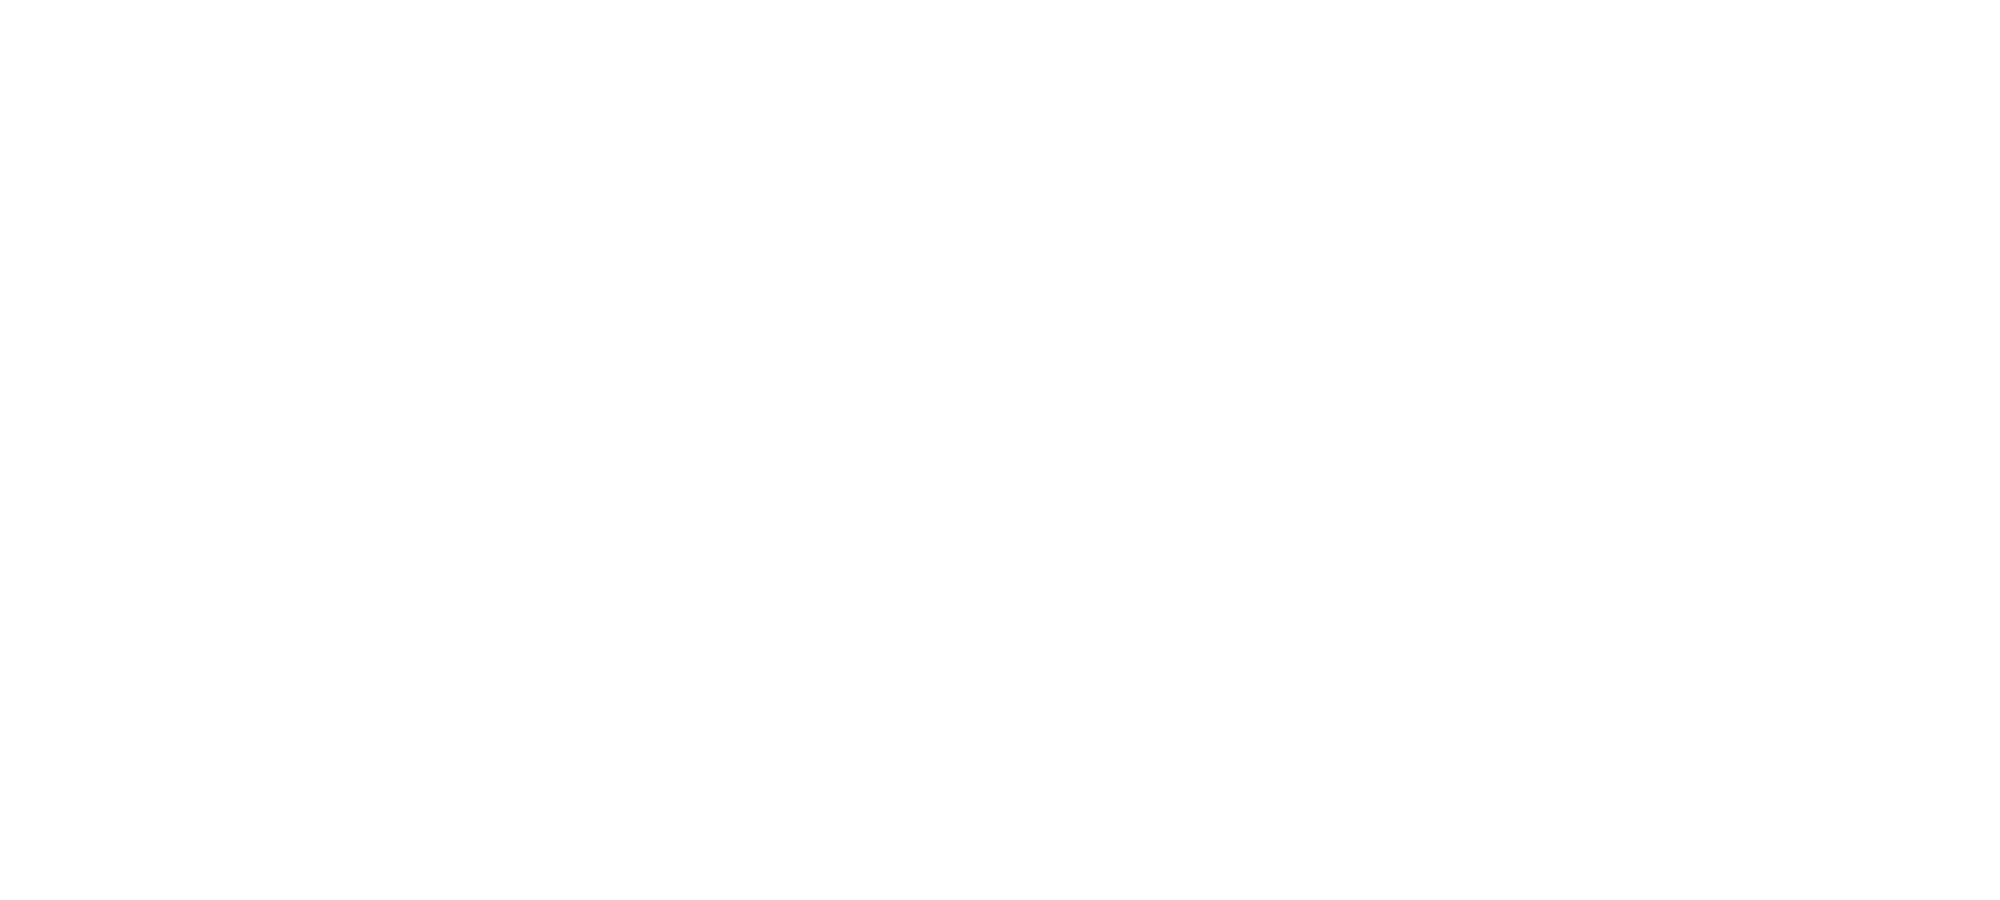

In [11]:
plt.figure(figsize=(10,4.5))

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp*1e3, w, 1e4)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.', capsize=2.5, capthick=0.5, alpha=0.5)

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp*1e3, w, 1e5)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='k', marker='.', capsize=2.5, capthick=0.5, ms=7.5)

plt.axhline(0.2326, c='C1', lw=2., label='PS subtraction') #from nomachine. Slightly off but well within uncr.
plt.annotate(
    r"Minimum baseline", xy=(2.4, 0.23261517), xytext=(1.9, 1.), color='C1', fontsize=14,
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.3", lw=1.5, ls='--', color='C1'),
)

plt.axhline(0, ls='--', c='k')

plt.xlabel(r'Baseline (M$\lambda$)')
plt.ylabel(r'Visibility (mJy)')

plt.xscale('linear')

plt.legend(loc='lower left')

plt.ylim(-0.5,2)
plt.xlim(-0.213090880614788,4.422176198057711)

plt.title('ALMA Band 3', loc='left', fontsize=14.)

plt.savefig('./band3_vissub.pdf',bbox_inches='tight')
plt.show()

In [12]:
UVTABLE = '../ps_subtraction/CITau_VLA_Ka_Combined_ConfAB_selfcal_ave_1ch_60s_uvtableVLA_frank.txt'

In [13]:
u, v, vis, w = frank.io.load_uvtable(UVTABLE)

  Loading UVTable


In [14]:
geom = frank.geometry.FixedGeometry(49.24, 11.28, -1.21e-06, -2.00e-07)

In [15]:
up, vp, visp = geom.apply_correction(u, v, vis)

<IPython.core.display.Javascript object>


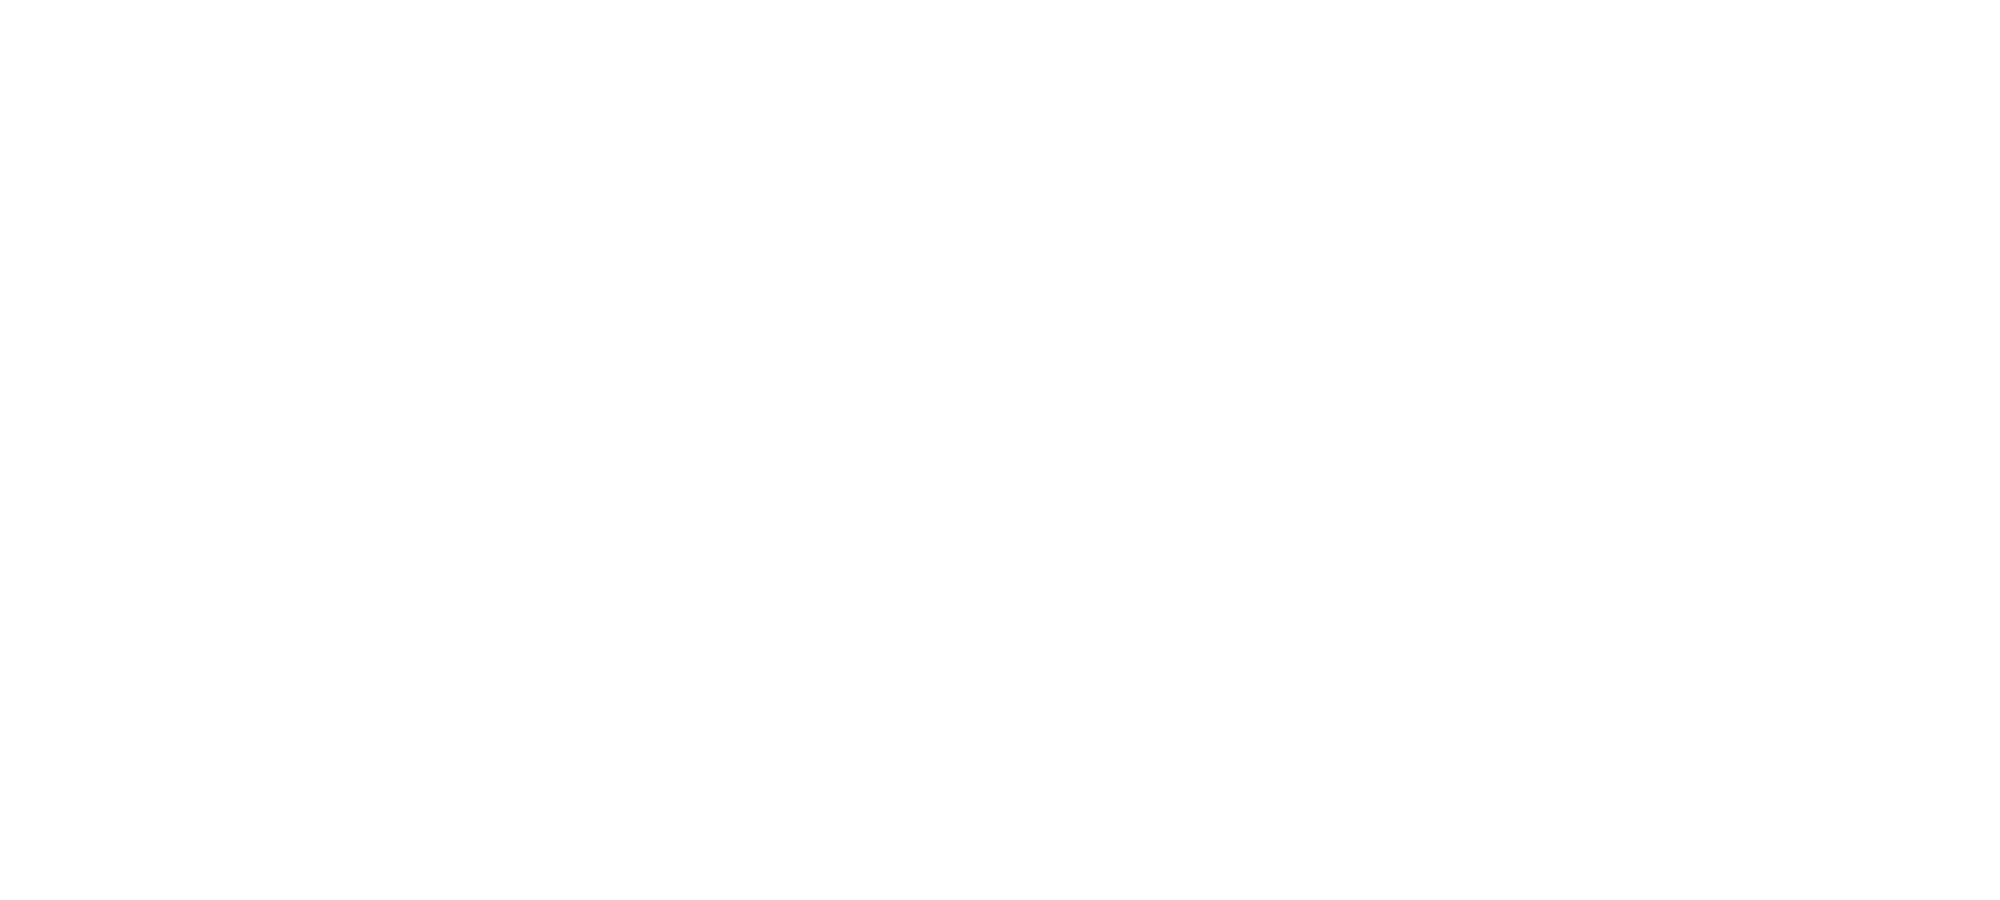

In [16]:
plt.figure(figsize=(10,4.5))

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp*1e3, w, 1e4)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.', capsize=2.5, capthick=0.5, alpha=0.5)

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp*1e3, w, 1e5)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='k', marker='.', capsize=2.5, capthick=0.5, ms=7.5)

plt.axhline(0.1563, c='C1', lw=2., label='PS subtraction')
plt.annotate(
    r"Minimum baseline", xy=(1.7, 0.1563), xytext=(0.40, 0.35), color='C1', fontsize=14,
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.3", lw=1.5, ls='--', color='C1'),
)

plt.axhline(0, ls='--', c='k')

plt.xlabel(r'Baseline (M$\lambda$)')
plt.ylabel(r'Visibility (mJy)')

plt.xscale('log')

plt.legend(loc='lower left')

plt.ylim(-0.1,0.5)
plt.xlim(5e-3,5)

plt.title('VLA Ka Band', loc='left', fontsize=14.)

plt.savefig('./bandKa_vissub.pdf',bbox_inches='tight')
plt.show()

Plot fits -- ALMA Band 7

In [17]:
data = load_uv_table(
    uvtable  = '../statwt/uvtable_CI_Tau_B7.txt',
    restable = '../statwt/band7/CI_Tau_B7_frank_uv_resid.txt',
    geom     = frank.geometry.FixedGeometry(49.24, 11.28, 4.75e-05, -8.36e-05)
)

  Loading UVTable
  Loading UVTable


<IPython.core.display.Javascript object>


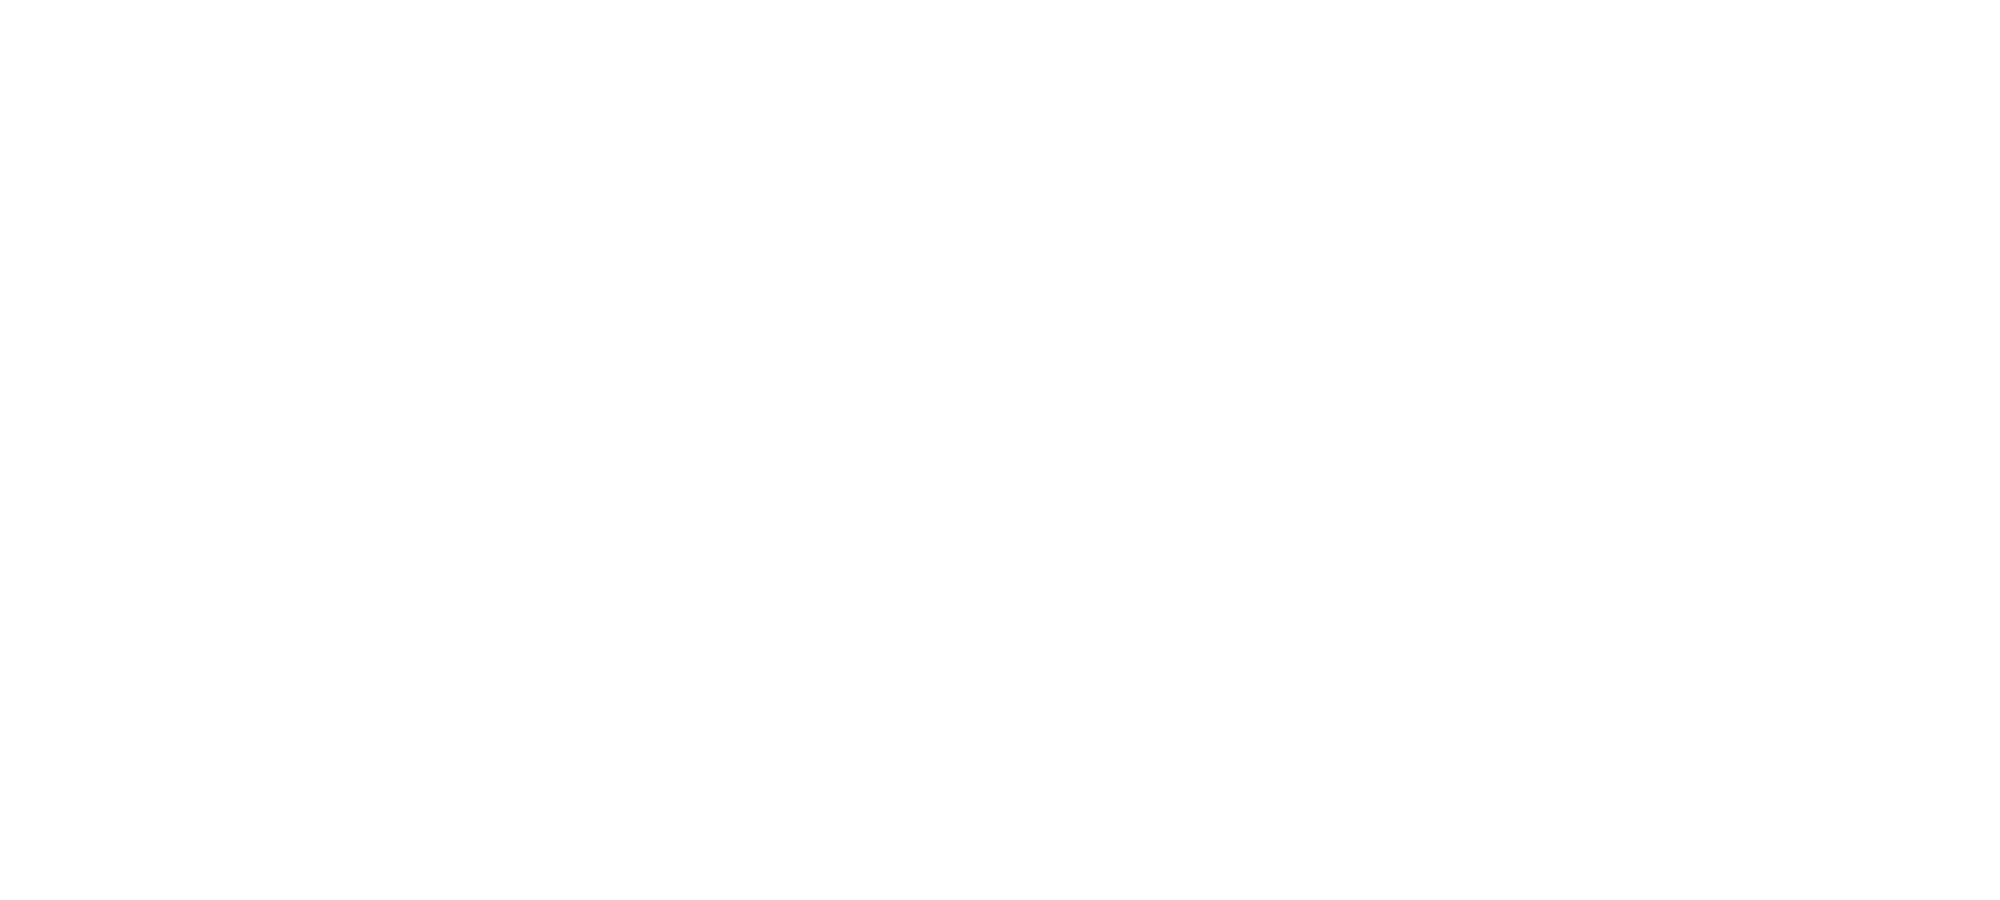

/var/folders/lz/yv59n4jx71vbz95j_0sxfsw00000gn/T/ipykernel_28340/3158172145.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [18]:
plot_paper(
    data          = data,
    filename      = '../nostatwt/band7/CI_Tau_B7_frank_visibilities_bestfit.dat',
    PSsub         = 0.,
    ylim          = [-10,25],
    ylim_res      = [-7.5,7.5],
    ylim_axin     = [5e-1,1e3],
    xlim          = [-0.15936235803021218, 3.65936235803021218],
    titlename     = 'ALMA Band 7',
    figname       = './band7_visfit.pdf',
    axin_position = [0.9,0.90,0.1,0.1],
    labelpad_vis  = 4.,
    labelpad_res  = 14.,
)

Plot fits -- ALMA Band 6

In [19]:
data = load_uv_table(
    uvtable  = '../statwt/uvtable_CI_Tau_B6_statwt_onechannel.txt',
    restable = '../statwt/band6/CI_Tau_B6_frank_uv_resid.txt',
    geom     = frank.geometry.FixedGeometry(49.24, 11.28, 1.99e-03, 1.52e-03)
)

  Loading UVTable
  Loading UVTable


<IPython.core.display.Javascript object>


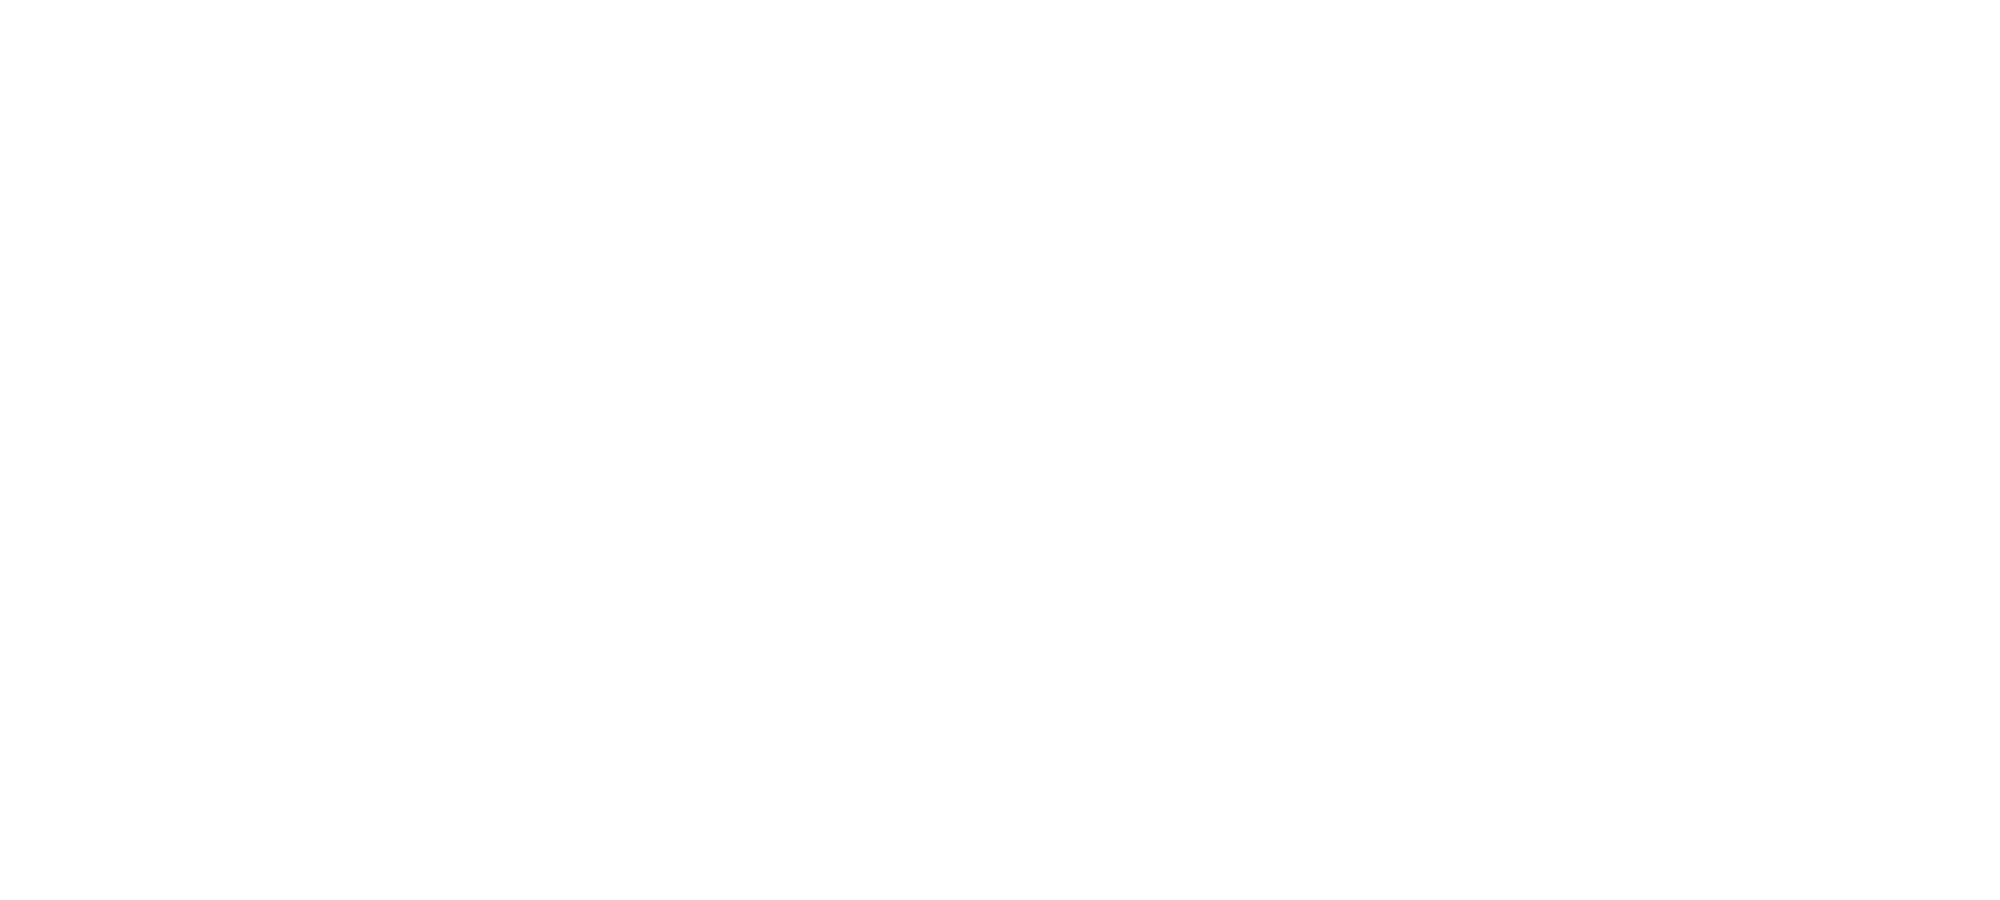

/var/folders/lz/yv59n4jx71vbz95j_0sxfsw00000gn/T/ipykernel_28340/3158172145.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [20]:
plot_paper(
    data          = data,
    filename      = '../statwt/band6/CI_Tau_B6_frank_visibilities_bestfit.dat',
    PSsub         = 0.,
    ylim          = [-2,+8],
    ylim_res      = [-1.4,1.4],
    ylim_axin     = [3e-1,3e2],
    xlim          = [-0.356180000917239, 6.725709288923519],
    titlename     = 'ALMA Band 6',
    figname       = './band6_visfit.pdf',
    axin_position = [0.9,0.91,0.1,0.1],
    labelpad_vis  = 14.,
    labelpad_res  = 14.,
)

Plot fits -- ALMA Band 3

In [21]:
data = load_uv_table(
    uvtable  = '../statwt/uvtable_CI_Tau_B3_statwt_onechannel.txt',
    restable = '../statwt/band3_pssub/CI_Tau_B3_frank_uv_resid.txt',
    geom     = frank.geometry.FixedGeometry(49.24, 11.28, 5.88e-04, -1.14e-03)
)

  Loading UVTable
  Loading UVTable


<IPython.core.display.Javascript object>


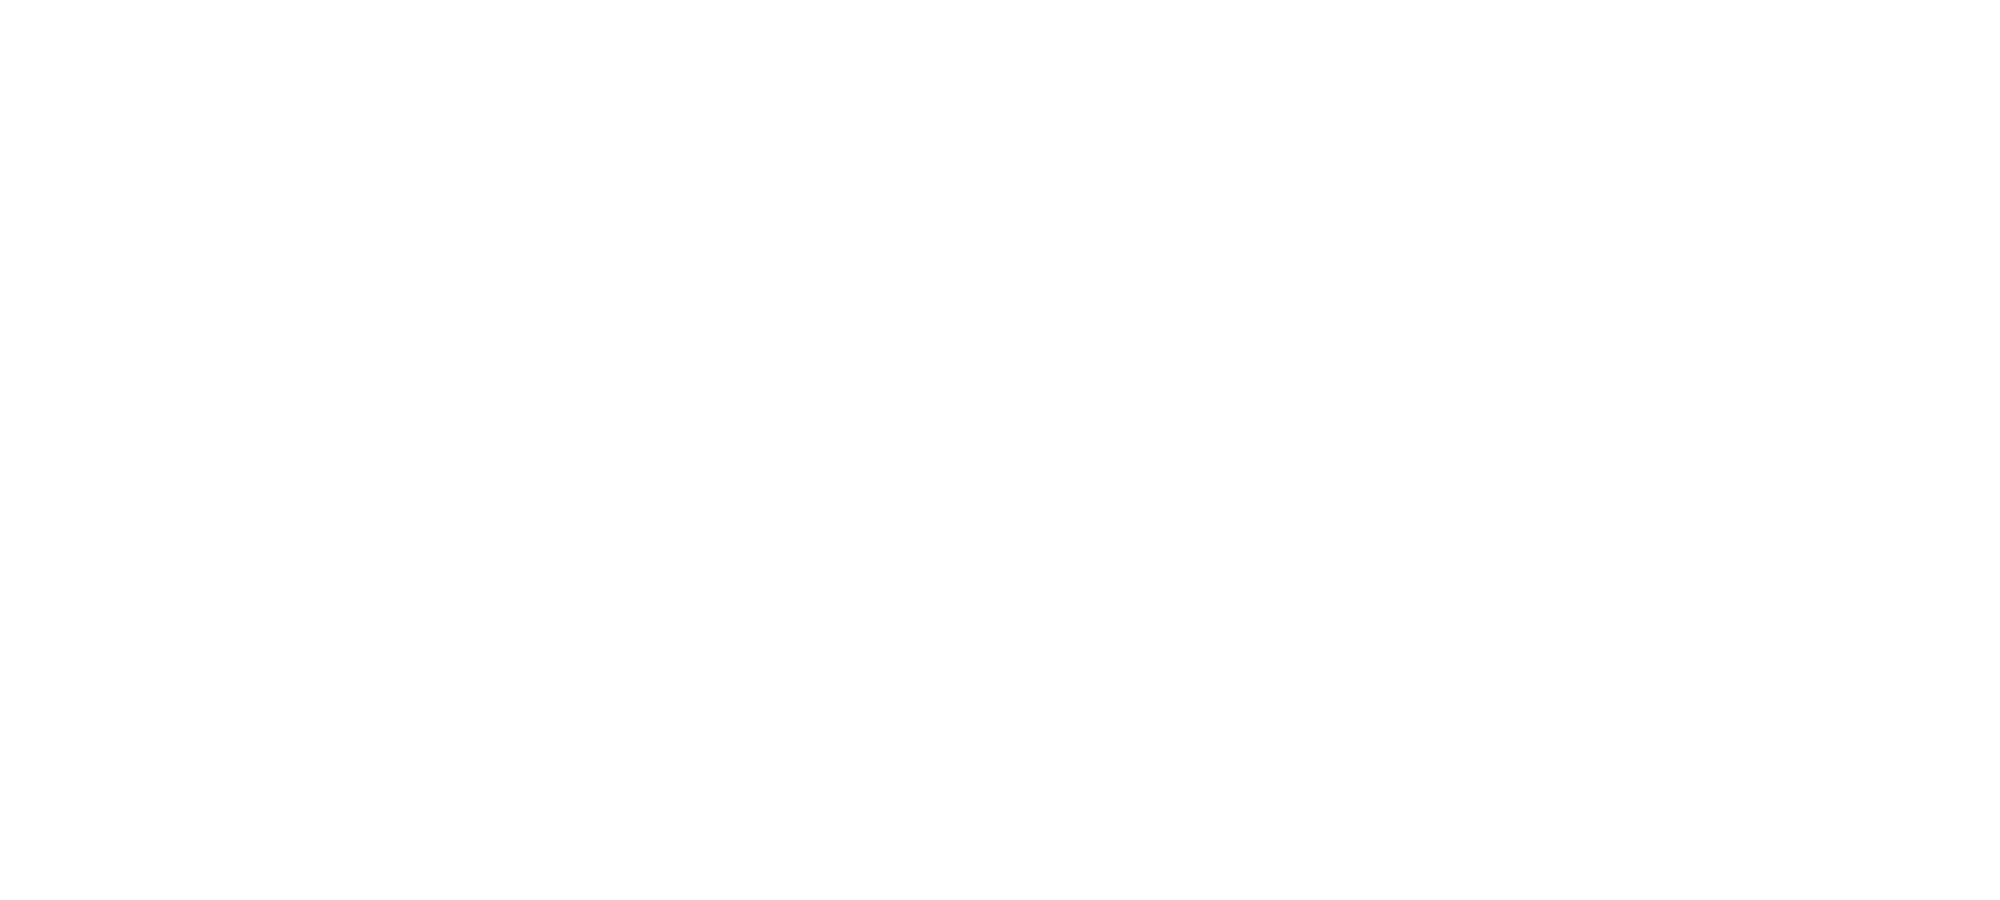

/var/folders/lz/yv59n4jx71vbz95j_0sxfsw00000gn/T/ipykernel_28340/3158172145.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [22]:
plot_paper(
    data          = data,
    filename      = '../statwt/band3_pssub/CI_Tau_B3_frank_visibilities_bestfit.dat',
    PSsub         = 0.2326,
    ylim          = [-0.5,2],
    ylim_res      = [-0.7,0.7],
    ylim_axin     = [3e-2,3e1],
    xlim          = [-0.223090880614788,4.422176198057711],
    titlename     = 'ALMA Band 3',
    figname       = './band3_visfit.pdf',
    axin_position = [0.9,0.9125,0.1,0.1],
    labelpad_vis  = 14.,
    labelpad_res  = 14.,
)

In [7]:
data = load_uv_table(
    uvtable  = '../ps_subtraction/CITau_VLA_Ka_Combined_ConfAB_selfcal_ave_1ch_60s_uvtableVLA_frank.txt', #'../ps_subtraction/bandKa/uvtable_CI_Tau_Ka_PSsub.txt',
    restable = '../nostatwt/bandKa_pssub/CI_Tau_Ka_frank_uv_resid.txt',
    geom     = frank.geometry.FixedGeometry(49.24, 11.28, -1.21e-06, -2.00e-07)
)

  Loading UVTable
  Loading UVTable


In [8]:
up, vp, visp, visp_res, w = data
qp                        = np.hypot(up,vp)

<IPython.core.display.Javascript object>


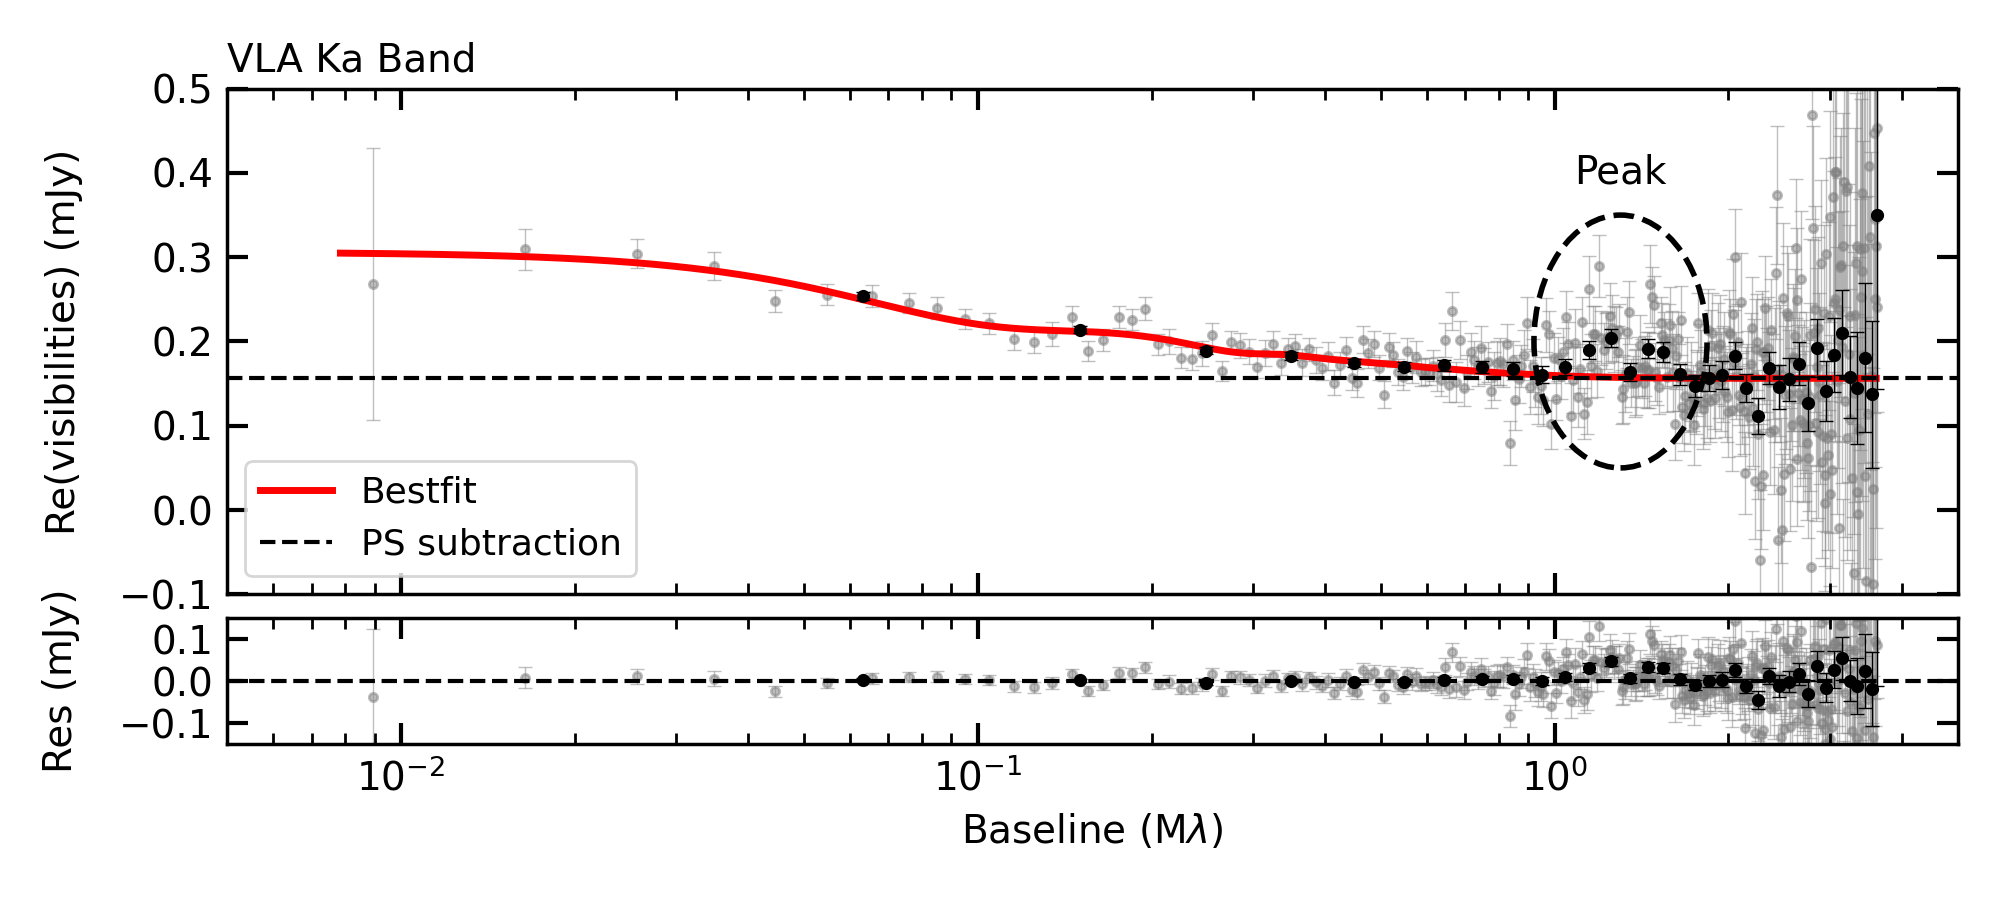

In [9]:
fig, axs = plt.subplots(2,1,figsize=(10,4.5),sharex=True,gridspec_kw={'height_ratios':[1,0.25]})
    
# axin = inset_axes(
#     axs[0], 
#     width  = 2.75,
#     height = 1.75,
#     loc    = 'upper right',
#     bbox_to_anchor=[0.9,0.92,0.1,0.1], 
#     bbox_transform=axs[0].figure.transFigure,
#     borderpad=0.5,
# )   

# axin.set_xlabel('Baseline (M$\lambda$)')
# axin.set_ylabel('Visibilities (mJy)')

# coords = axs[0].transAxes.inverted().transform(axin.get_tightbbox(fig.canvas.get_renderer()))
# border = 0.02
# width, height = coords[1] - coords[0] + 2. * border
# axs[0].add_patch(
#     plt.Rectangle(coords[0] - border, width, height, fc="w", transform=axs[0].transAxes, zorder=2))

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp*1e3, w, 1e4)
axs[0].errorbar(binned_vis.uv/1e6, binned_vis.V.real,         binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.', capsize=2.5, capthick=0.5, alpha=0.5, zorder=-1)

# axin.errorbar(  binned_vis.uv/1e6, np.abs(binned_vis.V.real), binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.', capsize=2.5, capthick=0.5, alpha=0.5, zorder=-1)

binned_res = frank.utilities.UVDataBinner(np.hypot(up,vp), visp_res*1e3, w, 1e4)
axs[1].errorbar(binned_res.uv/1e6, binned_res.V.real,         binned_res.error.real, ls='none', lw=0.5, c='gray', marker='.', capsize=2.5, capthick=0.5, alpha=0.5, zorder=-1)

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp*1e3, w, 1e5)
axs[0].errorbar(binned_vis.uv/1e6, binned_vis.V.real,         binned_vis.error.real, ls='none', lw=0.5, c='k',    marker='.', capsize=2.5, capthick=0.5, ms=7.5, zorder=10)

# axin.errorbar(  binned_vis.uv/1e6, np.abs(binned_vis.V.real), binned_vis.error.real, ls='none', lw=0.5, c='k',    marker='.', capsize=2.5, capthick=0.5, ms=7.5, zorder=10)

binned_res = frank.utilities.UVDataBinner(np.hypot(up,vp), visp_res*1e3, w, 1e5)
axs[1].errorbar(binned_res.uv/1e6, binned_res.V.real,         binned_res.error.real, ls='none', lw=0.5, c='k',    marker='.', capsize=2.5, capthick=0.5, ms=7.5, zorder=10)

filename = '../nostatwt/bandKa_pssub/CI_Tau_Ka_frank_visibilities_bestfit.dat'

qs, V_pred_deproj = np.loadtxt(filename, skiprows=1, unpack=True)
axs[0].plot(qs[qs<max(qp)]/1e6, V_pred_deproj[qs<max(qp)]*1e3 + 0.1563, c='red', lw=2.5, label=r'Bestfit')

# axin.loglog(qs[qs<max(qp)]/1e6, V_pred_deproj[qs<max(qp)]*1e3 + 0.1563, c='C1', lw=2.0, zorder=10)

axs[0].axhline(0.1563, ls='--', c='k', label='PS subtraction')
axs[1].axhline(0,      ls='--', c='k')

axs[1].set_xlabel(r'Baseline (M$\lambda$)')
axs[0].set_ylabel(r'Re(visibilities) (mJy)', labelpad=13)

axs[0].set_ylim(-0.1,0.5)

axs[1].set_ylabel(r'Res (mJy)', labelpad=14)

axs[1].set_ylim(-0.15,0.15)
axs[1].set_xlim(5e-3,5)

axs[1].set_xscale('log')

axs[0].legend(loc='lower left', fontsize=13)
axs[0].set_title('VLA Ka Band', loc='left', fontsize=14)

fig.tight_layout()
plt.subplots_adjust(hspace=0.075)

from matplotlib.transforms import ScaledTranslation
from matplotlib.patches import Ellipse

# Ellipse centre coordinates
x, y = 1.3, 0.2

# use the axis scale tform to figure out how far to translate 
ell_offset = ScaledTranslation(x, y, axs[0].transScale)

# construct the composite tform
ell_tform = ell_offset + axs[0].transLimits + axs[0].transAxes

axs[0].add_patch(Ellipse(xy=(0, 0), width=0.3, height=0.3, color="k", fill=False, lw=2, ls='--', zorder=5, transform=ell_tform))

axs[0].text(1.3,0.4,'Peak',horizontalalignment='center',verticalalignment='center')

plt.savefig('./bandKa_visfit.pdf',bbox_inches='tight')
plt.show()